# Visualize cumulative contibution by user over time

Derived from [`rephetio-rviz.ipynb`](https://github.com/dhimmel/thinklytics/blob/ea8569e0e2aa5a15be34143b9a91fc4b3685c4cf/viz/rephetio-rviz.ipynb)

In [4]:
library(magrittr)

## Read datasets

In [87]:
commit_df = readr::read_tsv('commits.tsv',  col_types = "ccccDccddcdddd" ) %>%
  dplyr::arrange(authored_datetime) %>%
  dplyr::filter(merge == 0) %>%
  dplyr::filter(characters_added != 0 | characters_deleted != 0) %>%
  dplyr::rename(username=author_name, date=authored_datetime)
  #dplyr::select(project, profile_id, username, first_name, last_name)
head(commit_df, 2)
print(commit_df)

Warning message:
“123 parsing failures.
row               col   expected    actual          file
 92 NA                14 columns 7 columns 'commits.tsv'
 93 authored_datetime date like  11        'commits.tsv'
 93 NA                14 columns 8 columns 'commits.tsv'
101 NA                14 columns 7 columns 'commits.tsv'
102 authored_datetime date like  0         'commits.tsv'
... ................. .......... ......... .............
See problems(...) for more details.
”

commit,username,author_email,committer_name,date,committed_datetime,summary,count,merge,parents,words_added,words_deleted,characters_added,characters_deleted
<chr>,<chr>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
3f8cdd531916e7cfb3a295f53142c6930ad5c124,Halie Rando,halie.rando@pennmedicine.upenn.edu,Halie Rando,2020-03-20,2020-03-20 15:18:05-04:00,initial commit,316,0,1780fac0ac6bba1260a9da3886061730fa5d2765,146,0,1000,0
02b07f0f32bdcd7075dde7370bb08e6e36d908a1,Halie Rando,halie.rando@pennmedicine.upenn.edu,Halie Rando,2020-03-20,2020-03-20 18:11:40-04:00,updated readme and abstract,317,0,3f8cdd531916e7cfb3a295f53142c6930ad5c124,85,61,630,414


# A tibble: 2,886 x 14
   commit username author_email committer_name date       committed_datet…
   <chr>  <chr>    <chr>        <chr>          <date>     <chr>           
 1 3f8cd… Halie R… halie.rando… Halie Rando    2020-03-20 2020-03-20 15:1…
 2 02b07… Halie R… halie.rando… Halie Rando    2020-03-20 2020-03-20 18:1…
 3 b9254… Halie R… halie.rando… GitHub         2020-03-21 2020-03-21 08:3…
 4 b0638… Halie R… halie.rando… GitHub         2020-03-21 2020-03-21 08:3…
 5 be27f… Halie R… halie.rando… Halie Rando    2020-03-21 2020-03-21 09:1…
 6 00338… Halie R… halie.rando… Halie Rando    2020-03-21 2020-03-21 12:1…
 7 78994… Casey G… greenescien… Casey Greene   2020-03-22 2020-03-22 11:3…
 8 3b15c… Halie R… halie.rando… Halie Rando    2020-03-22 2020-03-22 11:5…
 9 d2489… Halie R… halie.rando… Halie Rando    2020-03-22 2020-03-22 11:5…
10 cbd85… Halie R… halie.rando… Halie Rando    2020-03-22 2020-03-22 11:5…
# … with 2,876 more rows, and 8 more variables: summary <chr>, count <dbl>,
#

## Create a dataframe where each row is the cumulative contribution of a user at a given datetime

In [88]:
cumulative_df = commit_df %>%
  dplyr::group_by(username) %>%
  dplyr::mutate(cum_words = cumsum(words_added)) %>% 
  dplyr::mutate(cum_chars = cumsum(characters_added)) %>%
  dplyr::ungroup() %>%
  dplyr::select(username, date, cum_words, cum_chars)

cumulative_df %>% head(2)

username,date,cum_words,cum_chars
<chr>,<date>,<dbl>,<dbl>
Halie Rando,2020-03-20,146,1000
Halie Rando,2020-03-20,231,1630


In [89]:
min_date = as.Date(min(cumulative_df$date))
max_date = as.Date(max(cumulative_df$date))
#six_months = lubridate::duration(6, 'months')

even_date_df = dplyr::tibble(username = 'rando2', 
                             date = seq.Date(min_date, max_date, by='day'))
cumulative_df = dplyr::bind_rows(
  cumulative_df %$%
    dplyr::tibble(username = unique(username), date=min_date, cum_words=0, cum_chars=0),
  cumulative_df,
  cumulative_df %>%
    dplyr::group_by(username) %>%
    dplyr::summarize(date=max_date, cum_words = max(cum_words), cum_chars = max(cum_chars))
  ) %>%
  dplyr::full_join(even_date_df) %>%
  tidyr::complete(username, date) %>%
  tidyr::fill(username, cum_words, cum_chars) %>%
  dplyr::filter(as.Date(date) %in% as.Date(even_date_df$date)) %>% 
  dplyr::distinct()

cumulative_df %>% tail(10)

Joining, by = c("username", "date")


username,date,cum_words,cum_chars
<chr>,<date>,<dbl>,<dbl>
Yusha Sun,2021-08-31,351,3561
Yusha Sun,2021-09-01,351,3561
Yusha Sun,2021-09-02,351,3561
Yusha Sun,2021-09-03,351,3561
Yusha Sun,2021-09-04,351,3561
Yusha Sun,2021-09-05,351,3561
Yusha Sun,2021-09-06,351,3561
Yusha Sun,2021-09-07,351,3561
Yusha Sun,2021-09-08,351,3561


## Create a dataframe of users

In [90]:
# transformation = sqrt
transformation = identity

In [91]:
get_colors = colorRampPalette(RColorBrewer::brewer.pal(12, 'Paired'))

usage_df = commit_df %>%
  dplyr::group_by(username) %>%
  dplyr::summarize(
    first_date = min(date),
    total_chars = sum(characters_added),
    total_words = sum(words_added),
    total_chars_trans = transformation(total_chars)
  ) %>%
  dplyr::ungroup() %>%
  dplyr::arrange(first_date) %>%
  dplyr::mutate(y_position = cumsum(total_chars_trans) - total_chars_trans / 2) %>%
  dplyr::mutate(color = get_colors(length(username)))

usage_df$username = factor(usage_df$username, levels = usage_df$username)

# If a user appears twice here, fix that manually in above
usage_df %>%
  dplyr::select(username, first_date, total_chars, total_words) %>%
  readr::write_tsv('contributors.tsv')

usage_df %>% head(3)

username,first_date,total_chars,total_words,total_chars_trans,y_position,color
<fct>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Halie Rando,2020-03-20,1850375,234666,1850375,925187.5,#A6CEE3
Casey Greene,2020-03-22,300891,41177,300891,2000820.5,#80B6D6
Michael Robson,2020-03-23,969,38,969,2151750.5,#5B9EC9


## Create a smoothed dataframe of cumulative contribution

In [92]:
min_date_decimal = min(commit_df$date) %>% lubridate::decimal_date()
max_date_decimal = max(commit_df$date) %>% lubridate::decimal_date()
constant = nrow(even_date_df) / diff(lubridate::decimal_date(range(even_date_df$date)))

densify = function(df) {
  den = suppressWarnings(density(
    df$date %>% lubridate::decimal_date(),
    weights = df$cum_chars, bw=0.025,
    from = min_date_decimal, to = max_date_decimal))
  dplyr::tibble(date = lubridate::date_decimal(den$x), cum_chars = den$y / constant) %>% return
}

smooth_df = cumulative_df %>%
  dplyr::group_by(username) %>%
  dplyr::do(densify(.)) %>%
  dplyr::mutate(cum_chars_trans = transformation(cum_chars)) %>%
  dplyr::ungroup()

smooth_df$username = factor(smooth_df$username, levels = usage_df$username)

smooth_df %<>% dplyr::arrange(username, date)
smooth_df %>% head(2)

username,date,cum_chars,cum_chars_trans
<fct>,<dttm>,<dbl>,<dbl>
Halie Rando,2020-03-19 23:59:59,54196.60,54196.60
Halie Rando,2020-03-21 01:18:01,60722.74,60722.74


In [93]:
month_df = commit_df %>%
  dplyr::mutate(year_month=substr(date, 0, 7)) %>%
  tidyr::gather('diff_type', 'count', words_added) %>%
  dplyr::group_by(username, year_month, diff_type) %>%
  dplyr::summarize(
    count = sum(count)
  ) %>%
  dplyr::ungroup()
month_df %>% head(3)

`summarise()` has grouped output by 'username', 'year_month'. You can override using the `.groups` argument.


username,year_month,diff_type,count
<chr>,<chr>,<chr>,<dbl>
Adam MacLean,2020-03,words_added,1051
Adam MacLean,2020-04,words_added,384
Adam MacLean,2020-05,words_added,112


### Visualize contribution by month

In [83]:
# Create year_month breaks to gaurantee no missing months
`%m+%` = lubridate::`%m+%`
year_month_breaks = format(seq(min(commit_df$date), max(commit_df$date) %m+% months(1), by = "month"), "%Y-%m")


year_month_labeler = function(year_month) {
  # Function to return axis labels for every third year_month
  date_ = lubridate::ymd(year_month, truncated = 1)
  month_ = lubridate::month(date_)
  if (month_ %% 3 == 1) {
    return(format(date_, "%b %Y"))
  }
  return("")
}
year_month_labeler = Vectorize(year_month_labeler)

# diff_type colors
diff_type_colors = c(
  words_added = '#28A745',
  words_deleted = '#CB2431'
)

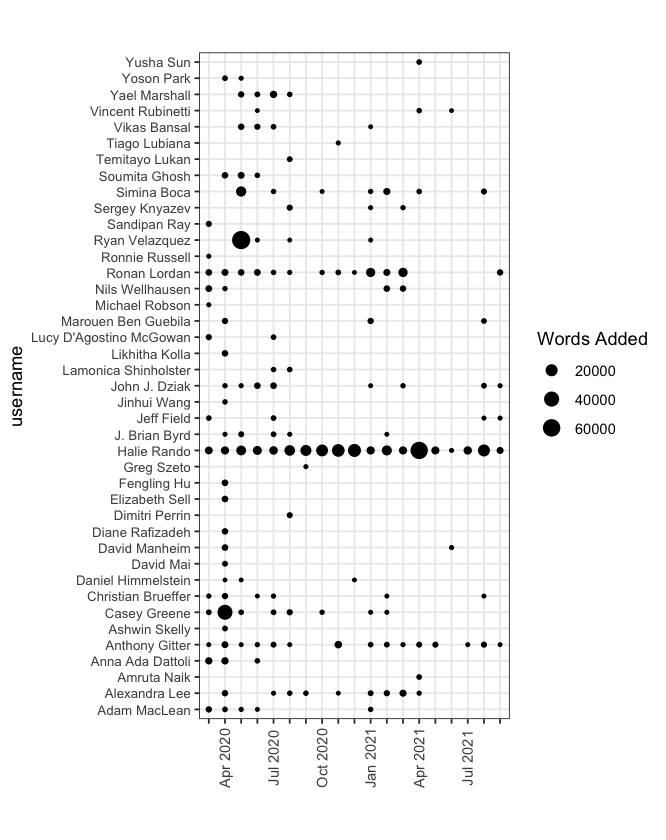

In [84]:
# Set figure dimensions
width = 5.55
height = 7
options(repr.plot.width=width, repr.plot.height=height)

gg = month_df %>%
  dplyr::filter(diff_type %in% c('words_added', 'words_deleted')) %>%
  dplyr::arrange(desc(count), desc(diff_type)) %>%
  ggplot2::ggplot(ggplot2::aes(x=year_month, y = username, size = count)) +
  ggplot2::geom_point(stroke=1) +
  #ggplot2::scale_y_discrete(limits=usage_df$username, position = 'top', labels=y_labels, name=NULL) #+
  ggplot2::scale_x_discrete(limits = year_month_breaks, labels=year_month_labeler, name=NULL) +
  ggplot2::scale_size_area(max_size = 3.8, name='Words Added') +
  #ggplot2::scale_color_manual(values=diff_type_colors, name=NULL, labels=c('added')) +
  ggplot2::coord_fixed() +
  ggplot2::theme_bw() +
  ggplot2::theme(
    axis.text.x = ggplot2::element_text(angle = 90, vjust = 0.5),
    axis.text.y = ggplot2::element_text(size=8))

gg

In [85]:
# Save image to file
ggplot2::ggsave(gg, filename = 'covid19-review-contribution-dot.png', dpi = 300, width = width, height = height, bg = 'transparent')
ggplot2::ggsave(gg, filename = 'covid19-review-contribution-dot.svg', width = width, height = height, bg = 'transparent')
ggplot2::ggsave(gg, filename = 'covid19-review-contribution-dot.pdf', width = width, height = height, bg = 'transparent')

## Summary statistics

In [86]:
min_date
max_date
max_date - min_date

[1] "2020-03-20"

[1] "2021-09-09"

Time difference of 538 days

## Package information

In [17]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS  10.16

Matrix products: default
BLAS/LAPACK: /Users/halierando/opt/miniconda3/envs/contrib-viz/lib/R/lib/libRblas.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] gdtools_0.1.7 magrittr_1.5 

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.4.6       plyr_1.8.6         pillar_1.4.3       compiler_3.5.1    
 [5] RColorBrewer_1.1-2 base64enc_0.1-3    tools_3.5.1        digest_0.6.25     
 [9] uuid_0.1-4         gtable_0.3.0       jsonlite_1.6.1     lubridate_1.7.4   
[13] evaluate_0.14      lifecycle_1.0.0    tibble_3.0.1       pkgconfig_2.0.3   
[17] rlang_0.4.10       IRdisplay_0.7.0    cli_2.0.2          IRkernel_0.8.15   
[21] repr_1.1.0         dplyr_1.0.5        stringr_1.4.0      generics_0.1.0    
[25] vctrs_0.3.7      